In [1]:
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
absolute_path = '/Users/aygalic/OneDrive/polimi/Thesis/data/quant/'

# Exploring the Dataset

In [3]:
# getting entries ready
# each couple of entries correspond to one patient

entries = os.listdir(absolute_path)
entries_transcripts = [e for e in entries if "transcripts" in e ]

# Building a TensorFlow input pipeline

## We want to build a tf.Dataset from this

In [6]:
# from filename to tensor

def load_patient_data(filename):
  #specify read types for our data
  read_types = [float()]
  # get a first sample to base everything of
  text = pathlib.Path(absolute_path + filename).read_text()
  lines = text.split('\n')[1:-1]
  features = tf.io.decode_csv(lines, record_defaults=read_types, field_delim = "\t", select_cols=[3]) 
  data = tf.convert_to_tensor(features)[0]

  return data

# Feed it into a net

In [7]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras

# now we build a tf.dataset with all patients inside


## Load all the data


In [8]:
# load the dataset into a list using the first pipeline

train_ds = [load_patient_data(e) for e in entries_transcripts]
train_ds = [e for e in train_ds if e.shape == (95309)] 

In [9]:
train_ds

[<tf.Tensor: shape=(95309,), dtype=float32, numpy=
 array([ 0.     ,  6.55631,  0.     , ..., 21.601  , 14.5302 , 43.2891 ],
       dtype=float32)>,
 <tf.Tensor: shape=(95309,), dtype=float32, numpy=
 array([ 0.    ,  2.6901,  0.    , ..., 28.7308, 33.4212, 42.899 ],
       dtype=float32)>,
 <tf.Tensor: shape=(95309,), dtype=float32, numpy=
 array([  3.11716,  56.9107 ,  12.8459 , ..., 346.531  , 649.73   ,
        311.662  ], dtype=float32)>,
 <tf.Tensor: shape=(95309,), dtype=float32, numpy=
 array([ 0.      ,  2.80586 ,  0.365711, ..., 37.2859  , 22.7498  ,
        95.4406  ], dtype=float32)>,
 <tf.Tensor: shape=(95309,), dtype=float32, numpy=
 array([ 0.      ,  2.58126 ,  0.120558, ..., 63.181   , 12.8496  ,
        84.2115  ], dtype=float32)>,
 <tf.Tensor: shape=(95309,), dtype=float32, numpy=
 array([ 0.      ,  7.04612 ,  0.365312, ..., 45.6259  , 32.0575  ,
        60.2416  ], dtype=float32)>,
 <tf.Tensor: shape=(95309,), dtype=float32, numpy=
 array([  0.     ,   7.51996,   3

## process it

In [10]:
import scipy



In [11]:
data_array = np.array(train_ds)
MAD = scipy.stats.median_abs_deviation(data_array)
gene_selected = [True if val > 10 else False for val in MAD]
data_selected = data_array[:,gene_selected]

In [12]:
p = sum(gene_selected)
p

2735

In [13]:
data_selected = data_array[:,gene_selected]

In [14]:
data_selected.shape

(4755, 2735)

In [15]:
batch_size = 64

# turn it into a tf.data.Dataset object
x_train = tf.data.Dataset.from_tensor_slices(data_selected)

dataset = x_train.batch(batch_size)


In [16]:
dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 2735), dtype=tf.float32, name=None)>

# train it

In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [18]:
latent_dim = 64

t_shape = (p)
encoder_inputs = keras.Input(shape=t_shape)
x = layers.Flatten()(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.UnitNormalization()(x) # to avoid overloading float32
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dense(256, activation = "relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2735)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 2735)         0           ['input_1[0][0]']                
                                                                                                  
 unit_normalization (UnitNormal  (None, 2735)        0           ['flatten[0][0]']                
 ization)                                                                                         
                                                                                                  
 dense (Dense)                  (None, 256)          700416      ['unit_normalization[0][0]'

In [19]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(p, activation="relu")(x)

#decoder_outputs = layers.Reshape((1, 95309))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 2735)              702895    
                                                                 
Total params: 719,535
Trainable params: 719,535
Non-trainable params: 0
_________________________________________________________________


In [20]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(0)
                )
            reconstruction_loss = keras.losses.mean_squared_error(data, reconstruction) # which one is right ???
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [22]:
hist = vae.fit(dataset, epochs=5000) # do 1K



Epoch 1/5000


2023-07-11 16:58:21.470518: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


75/75 [==============================] - 2s 8ms/step - loss: 2734207.6151 - reconstruction_loss: 2500634.2500 - kl_loss: 10212.5312
Epoch 2/5000
75/75 [==============================] - 1s 12ms/step - loss: 2059610.0411 - reconstruction_loss: 1641173.8750 - kl_loss: 54393.0078
Epoch 3/5000
75/75 [==============================] - 1s 14ms/step - loss: 1174872.9572 - reconstruction_loss: 953048.3125 - kl_loss: 68460.2891
Epoch 4/5000
75/75 [==============================] - 1s 13ms/step - loss: 915676.3635 - reconstruction_loss: 821054.7500 - kl_loss: 54003.9219
Epoch 5/5000
75/75 [==============================] - 1s 12ms/step - loss: 881749.7747 - reconstruction_loss: 808474.1250 - kl_loss: 42299.5508
Epoch 6/5000
75/75 [==============================] - 1s 12ms/step - loss: 867953.5247 - reconstruction_loss: 805305.3750 - kl_loss: 34325.1016
Epoch 7/5000
75/75 [==============================] - 1s 12ms/step - loss: 860675.9104 - reconstruction_loss: 804033.2500 - kl_loss: 29279.8926
E

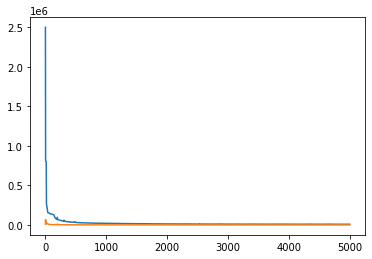

In [23]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])




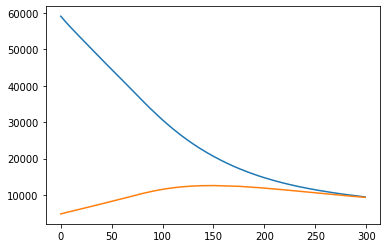

In [62]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])


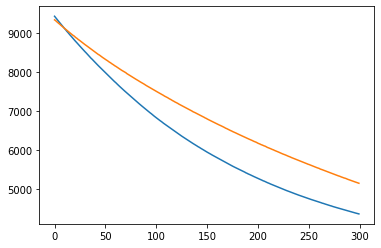

In [66]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])


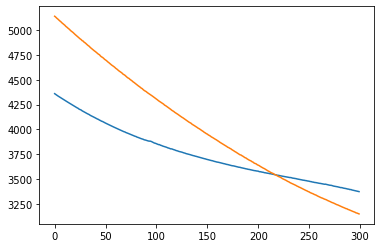

In [69]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])


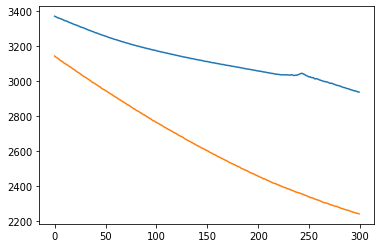

In [72]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])


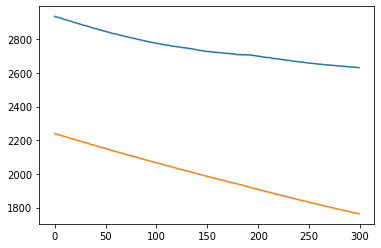

In [75]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])



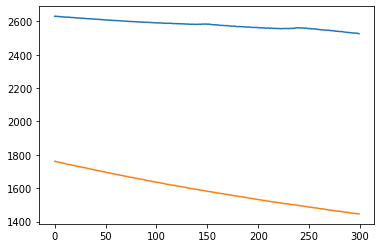

In [78]:
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['kl_loss'])



[75230.9609375, 74665.765625, 74096.4609375, 73539.375, 72998.53125, 72482.6015625, 71985.0078125, 71515.4140625, 71064.6015625, 70632.46875, 70216.8984375, 69816.0234375, 69429.546875, 69056.59375, 68692.1328125, 68339.1640625, 67993.5078125, 67657.4296875, 67329.9453125, 67009.2734375, 66695.9296875, 66391.3046875, 66086.6796875, 65796.3125, 65505.87109375, 65221.31640625, 64941.6953125, 64666.8046875, 64398.9921875, 64131.14453125]


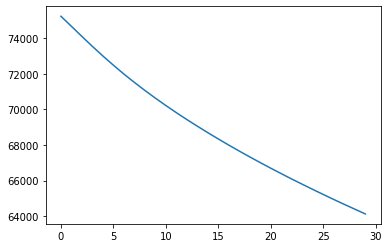

In [59]:

plt.plot(hist.history['loss'])

print(hist.history['loss'])


In [24]:
#autoencoder.save('../workfiles/placeholder_model')
vae.encoder.save('../workfiles/vae_model')



INFO:tensorflow:Assets written to: ../workfiles/vae_model/assets
